In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
import pandas as pd

SB_normais = pd.read_csv('../gerais/SB_geral.csv').query("normal_ecg == True")
ST_normais = pd.read_csv('../gerais/ST_geral.csv').query("normal_ecg == True")
AF_normais = pd.read_csv('../gerais/AF_geral.csv').query("normal_ecg == True")
dAVB_normais = pd.read_csv('../gerais/1dAVB_geral.csv').query("normal_ecg == True")
RBBB_normais = pd.read_csv('../gerais/RBBB_geral.csv').query("normal_ecg == True")
LBBB_normais = pd.read_csv('../gerais/LBBB_geral.csv').query("normal_ecg == True")

merged_df = SB_normais[['exam_id', 'tipo']].merge(ST_normais[['exam_id', 'tipo']], on='exam_id', suffixes=('_SB', '_ST'), how='inner')
merged_df = merged_df.merge(AF_normais[['exam_id', 'tipo']], on='exam_id', how='inner')
merged_df = merged_df.rename(columns={'tipo': 'tipo_AF'})
merged_df = merged_df.merge(RBBB_normais[['exam_id', 'tipo']], on='exam_id', suffixes=('', '_RBBB'), how='inner')
merged_df = merged_df.rename(columns={'tipo': 'tipo_RBBB'})
merged_df = merged_df.merge(LBBB_normais[['exam_id', 'tipo']], on='exam_id', suffixes=('', '_LBBB'), how='inner')
merged_df = merged_df.rename(columns={'tipo': 'tipo_LBBB'})
merged_df.to_csv('_analise.csv', index=False)


In [36]:
merged_df['all_same_tipo'] = merged_df.filter(like='tipo').nunique(axis=1) == 1

proportion_same_tipo = merged_df['all_same_tipo'].mean()

print(f"Proportion of rows where all 'tipo' values are the same: {proportion_same_tipo:.2%}")

Proportion of rows where all 'tipo' values are the same: 90.86%


In [40]:
target_value = 'N_clusterD'

rows_with_target = merged_df[merged_df.filter(like='tipo').eq(target_value).any(axis=1)]
rows_with_consensus = rows_with_target[rows_with_target.filter(like='tipo').eq(target_value).all(axis=1)]

percentage_consensus = len(rows_with_consensus) / len(rows_with_target) * 100

print(f"Percentage of rows with '{target_value}' that have consensus: {percentage_consensus:.2f}%")

Percentage of rows with 'N_clusterD' that have consensus: 0.00%


In [55]:
# Define the value of interest
target_value = 'N_clusterD'

# Filter rows where at least one 'tipo' column has the value 'N_clusterD'
rows_with_target = merged_df[
    (merged_df['tipo_SB'] == target_value) |
    (merged_df['tipo_ST'] == target_value) |
    (merged_df['tipo_AF'] == target_value) |
    (merged_df['tipo_RBBB'] == target_value) |
    (merged_df['tipo_LBBB'] == target_value)
]

# Check if all 'tipo' columns in these rows have the value 'N_clusterD'
rows_with_consensus = rows_with_target[
    (rows_with_target['tipo_SB'] == target_value) &
    (rows_with_target['tipo_ST'] == target_value) &
    (rows_with_target['tipo_AF'] == target_value) &
    (rows_with_target['tipo_RBBB'] == target_value) &
    (rows_with_target['tipo_LBBB'] == target_value)
]

# Calculate the percentage
if len(rows_with_target) > 0:
    percentage_consensus = len(rows_with_consensus) / len(rows_with_target) * 100
else:
    percentage_consensus = 0.0  # Handle the case where there are no rows with the target value

print(len(rows_with_consensus), ', ', len(rows_with_target) )
print(f"Percentage of rows with '{target_value}' that have consensus: {percentage_consensus:.2f}%")


0 ,  1806
Percentage of rows with 'N_clusterD' that have consensus: 0.00%


In [56]:
target_value = 'N_clusterN'
rows_with_target = merged_df[
    (merged_df['tipo_SB'] == target_value) |
    (merged_df['tipo_ST'] == target_value) |
    (merged_df['tipo_AF'] == target_value) |
    (merged_df['tipo_RBBB'] == target_value) |
    (merged_df['tipo_LBBB'] == target_value)
]
rows_with_consensus = merged_df[
    (rows_with_target['tipo_SB'] == target_value) &
    (rows_with_target['tipo_ST'] == target_value) &
    (rows_with_target['tipo_AF'] == target_value) &
    (rows_with_target['tipo_RBBB'] == target_value) &
    (rows_with_target['tipo_LBBB'] == target_value)
]

percentage_consensus = len(rows_with_consensus) / len(rows_with_target) * 100

print(len(rows_with_consensus), ', ', len(rows_with_target) )
print(f"Percentage of rows with '{target_value}' that have consensus: {percentage_consensus:.2f}%")

18172 ,  20000
Percentage of rows with 'N_clusterN' that have consensus: 90.86%


                                   Proportion
tipo_SB vs tipo_AF                    0.97920
tipo_AF vs tipo_LBBB                  0.97245
tipo_ST vs tipo_AF                    0.96090
tipo_SB vs tipo_LBBB                  0.95875
tipo_ST vs tipo_LBBB                  0.95870
tipo_RBBB vs tipo_LBBB                0.95845
tipo_AF vs tipo_RBBB                  0.95040
tipo_SB vs tipo_ST                    0.94700
tipo_SB vs tipo_RBBB                  0.93680
tipo_ST vs tipo_RBBB                  0.93320
tipo_LBBB vs num_unique_tipos         0.00000
tipo_LBBB vs all_same_tipo            0.00000
tipo_RBBB vs num_unique_tipos         0.00000
tipo_RBBB vs all_same_tipo            0.00000
tipo_ST vs num_unique_tipos           0.00000
tipo_AF vs num_unique_tipos           0.00000
tipo_AF vs all_same_tipo              0.00000
tipo_ST vs all_same_tipo              0.00000
tipo_SB vs num_unique_tipos           0.00000
tipo_SB vs all_same_tipo              0.00000
all_same_tipo vs num_unique_tipos 

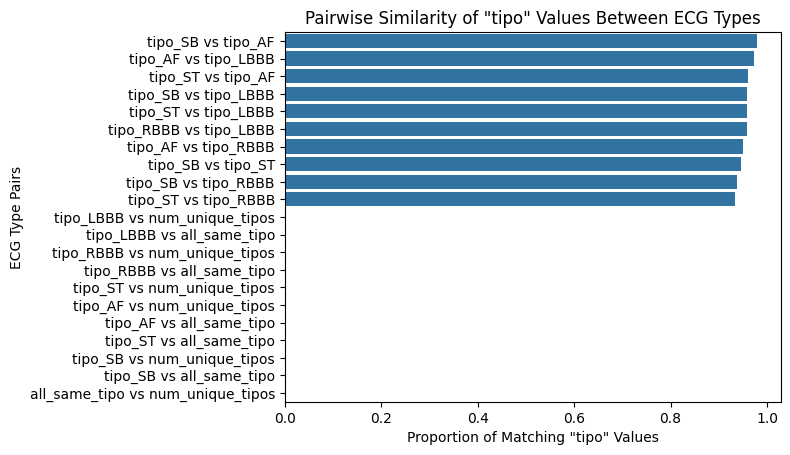

In [39]:
# Create pairwise comparisons between 'tipo' columns
pairs = [(a, b) for idx, a in enumerate(merged_df.filter(like='tipo').columns) 
                 for b in merged_df.filter(like='tipo').columns[idx + 1:]]

# Calculate the proportion of matching 'tipo' values for each pair
pairwise_similarity = {}
for a, b in pairs:
    pairwise_similarity[f'{a} vs {b}'] = (merged_df[a] == merged_df[b]).mean()

# Convert to DataFrame for easier analysis
pairwise_similarity_df = pd.DataFrame.from_dict(pairwise_similarity, orient='index', columns=['Proportion'])
pairwise_similarity_df.sort_values(by='Proportion', ascending=False, inplace=True)

print(pairwise_similarity_df)

# Plot the pairwise similarity
sns.barplot(x=pairwise_similarity_df['Proportion'], y=pairwise_similarity_df.index)
plt.title('Pairwise Similarity of "tipo" Values Between ECG Types')
plt.xlabel('Proportion of Matching "tipo" Values')
plt.ylabel('ECG Type Pairs')
plt.show()